# Classification with Tensorflow/Keras

In this notebook we will use a simple DNN for classification. We will use the vehicle emissions dataset provided by the city of Albuquerque [here](https://www.cabq.gov/abq-data/), in order to predict whether a vehicle will fail the emissions test with the goal to reduce pollution in Albuquerque. We borrow a lot from work done [here](https://github.com/Guli-Y/wimlds_emissions).

Since it is a large dataset, we have taken a subset of the data. And we'll skip the exploration part.

In [31]:
# Import all the libraries I need
import numpy as np
import pandas as pd
from termcolor import colored
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout      # create layers

np.random.seed(42)
tf.random.set_seed(42)

df = pd.read_csv('../data/vehicle_emissions.csv', index_col=0)

**Variable Description:**

|Variable|Definition   | Key  |  Type |
|---|---|---|---|
| RESULT | Passed the test? |   0 = Yes, 1 = No | Dichotomous | 
| VIN | Vehicle Identification Number | Text | 17 Char |
| TEST_SDATE | Start of test date/time | MM/DD/YYYY HH:MM:SS | Date/Time |
| MODEL_YEAR | Vehicle Model Year |	Number | Year |
| GVWR | Gross Vehicle Weight | Number | Ratio |
| ENGINE_SIZE | Engine Size volume | Number | Ratio |
| ODOMETER | Odometer Reading, number of miles | Number | Ratio |
| MAKE | Vehicle Make | Text | Nominal |

In [32]:
df.head()

,TEST_SDATE,VIN,MODEL_YEAR,GVWR,ENGINE_SIZE,ODOMETER,RESULT,MAKE
0,2014-01-06 09:17:00,JTEHP21A470207451,2007,5360,3300,58795,0,TOYOTA
1,2014-12-05 12:29:00,JT3HN86R1Y0264434,2000,5250,3400,236529,0,TOYOTA
2,2014-12-02 11:45:00,2GTEC19TX31323349,2003,6100,5300,173509,0,GMC
3,2014-09-19 08:41:00,2C3LA53G68H231030,2008,3875,3500,57883,0,CHRYSLER
4,2014-10-20 13:28:00,1GCCS19X638205261,2003,3625,4300,198516,0,CHEVROLET


## Data Cleaning

Looking at the information about each column and the missing values shows us that we have to clean our data before we can use it for modelling.

In [33]:
# transform TEST_SDATE to datetime object
df['TEST_SDATE'] = pd.to_datetime(df['TEST_SDATE'])

We approximate vehicle age in years by subtracting the model year from the test year and adding 2 years to avoid zero-age vehicles (e.g., cars tested in their model year) before dividing mileage by age.

In [34]:
# engineering VEHICLE_AGE
df['VEHICLE_AGE'] = df.TEST_SDATE.dt.year.astype('int') - df.MODEL_YEAR.astype('int') + 2

We clean the VIN column and fill missing or zero GVWR values, if possible otherwise drop them.

In [35]:
print(colored(f'\nRecords in input data: {df.shape[0]}', 'red'))
# get median GVWR for each VIN
# clean VIN
df['VIN'] = df['VIN'].astype('string').str.strip().str.lower()
# get median GVWR
tmp = df[['VIN', 'GVWR']].groupby('VIN').agg({'GVWR':'median'})
tmp.reset_index(inplace=True)
# merge tmp with df
df = df.merge(tmp, how='left', on='VIN', suffixes=('_0',''))
# replace 0 with np.nan
df.loc[df.GVWR==0, 'GVWR'] = np.nan
df.loc[df.GVWR_0==0, 'GVWR_0'] = np.nan
# using GVWR_0 fill missing values in GVWR
df['GVWR'] = df.GVWR.fillna(df.GVWR_0)
# keep GVW and drop GVWR_0
df = df.drop(columns=['GVWR_0'])
# drop na in GVWR
print('\nRecords with missing GVWR:', df.GVWR.isnull().sum())
df = df[~df.GVWR.isnull()]
# drop low numbers in GVWR
df = df[df.GVWR > 1000]
print(colored(f'\nRecords after droping rows where GVWR is < 1000 or missing: {df.shape[0]}', 'red'))


Records in input data: 164108

Records with missing GVWR: 6102

Records after droping rows where GVWR is < 1000 or missing: 157998


In order to have independent test results, only keep the first if there are multiple in 90 days.

In [36]:
# if a vehicle has multiple test records within 90 days, keep earliest record 
df = df.sort_values('TEST_SDATE')
df = df.loc[~(df.groupby('VIN')['TEST_SDATE'].diff() < np.timedelta64(90, 'D'))]
print(colored(f'\nRecords after keeping only the earliest test within 90 days for each vehicle: {df.shape[0]}', 'red'))


Records after keeping only the earliest test within 90 days for each vehicle: 146078


Now we can drop the `VIN` column as it does not contain useful information.

In [37]:
df = df.drop(columns=['VIN'])

Clean the `ODOMETER` column by removing zeros and `8888888` values.

In [38]:
# drop 0s in ODOMETER and remove 8888888
print('\nRecords where ODOMETER = 0:', df[df.ODOMETER==0].shape[0])
df = df[(df.ODOMETER!=0) & (df.ODOMETER!=8888888)]
print(colored(f'\nRecords after dropping rows where ODOMETER is 0 or 8,888,888: {df.shape[0]}', 'red'))


Records where ODOMETER = 0: 821

Records after dropping rows where ODOMETER is 0 or 8,888,888: 145195


We calculate the miles per year.

In [39]:
# engineer MILE_YEAR from ODOMETER
df['MILE_YEAR'] = np.round(df['ODOMETER']/df['VEHICLE_AGE'], 2)

Based on the engineered features `MILE_YEAR` and `VEHICLE_AGE` we remove clear outliers: records with over 40,000 miles per year and vehicles older than 10 years showing under 1,000 miles per year.

In [40]:
# remove the outliers
df = df[df.MILE_YEAR <= 40000]
df = df[~((df.VEHICLE_AGE > 10) & (df.MILE_YEAR < 1000))]
print(colored(f'\nRecords after dropping rows where MILE_YEAR > 40,000 or (VEHICLE_AGE > 10 and MILE_YEAR < 1,000): {df.shape[0]}', 'red'))


Records after dropping rows where MILE_YEAR > 40,000 or (VEHICLE_AGE > 10 and MILE_YEAR < 1,000): 144368


We calculate the engine - weight ratio.

In [41]:
# engineer ENGINE_WEIGHT_RATIO
df['ENGINE_WEIGHT_RATIO'] = np.round(df['ENGINE_SIZE']/df['GVWR'], 2)

We drop remaining nan's.

In [42]:
df = df.dropna()
df = df.reset_index(drop=True)

And select a subset of columns, which are most useful.

In [43]:
cols = ['MODEL_YEAR',
        'VEHICLE_AGE',
        'MILE_YEAR',
        'MAKE',
        'ENGINE_WEIGHT_RATIO',
        'RESULT'
        ]
df = df[cols]

To avoid an explosion of columns after one-hot encoding, we relabel any make appearing in less than 1% of cars as `other`.

In [44]:
make_threshold = 0.01
# create a make label 'other' for all makes that account for <1% of cars
value_counts_norm = df['MAKE'].value_counts(normalize = True)
to_other = value_counts_norm[value_counts_norm < make_threshold]
#print(f"\n{len(to_other)} make labels each account for less than {round((make_threshold *100), 2)}% of cars and together account for {(round(to_other.sum(), 4)) *100}% of cars")
to_keep = value_counts_norm[value_counts_norm >= make_threshold]
makes_keep = list(to_keep.index)
makes_keep.sort()
other_makes = [make for make in df['MAKE'].unique() if make not in makes_keep]
df['MAKE'] = df['MAKE'].replace(other_makes, 'other')
# one-hot encode the make column
df = pd.get_dummies(df, drop_first=True, dtype=float)

We split our data into train-, validation- and test-sets.

In [45]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('RESULT'))
val_labels = np.array(val_df.pop('RESULT'))
test_labels = np.array(test_df.pop('RESULT'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0699
Average class probability in validation set: 0.0690
Average class probability in test set:       0.0683


We see that we are dealing with a highly imbalanced data set. We will use class weights to deal with that.

Neural networks are highly sensitive to the scale of the input data, and small differences in scale can have a significant impact on the performance of the network. By properly scaling input data, we can ensure that the neural network is able to effectively learn and make accurate predictions. Therefore we add a normalizer layer which we adapt on the train set only, to avoid data leakage. 

In [46]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features)

Up to this point the steps should look familiar to you. But now we will create our very simple Dense Neural Network with: 
- a normalizer layer  
- a dense layer with 4 nodes and gelu activation
- a hidden layers with 4 nodes and gelu activation  
- a dropout layer (The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.)
- an output layer which is used to predict a car's test result. The output layer has a sigmoid activation function, which is used to 'squash' all our outputs to be between 0 and 1.

We then compile our NN with different hyperparameters like:

1. Optimizers:
While the architecture of the Neural Network plays an important role when extracting information from data, all (most) are being optimized through update rules based on the gradient of the loss function.
The update rules are determined by the Optimizer. The performance and update speed may heavily vary from optimizer to optimizer. The gradient tells us the update direction, but it is still unclear how big of a step we might take. Short steps keep us on track, but it might take a very long time until we reach a (local) minimum. Large steps speed up the process, but it might push us off the right direction.
Adam and RMSProp are two very popular optimizers still being used in most neural networks. Both update the variables using an exponential decaying average of the gradient and its squared. But there are more, have a [look](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).

2. Loss
Different [loss functions](https://www.tensorflow.org/api_docs/python/tf/keras/losses)

3. Metrics

4. and so on. There are many. Have a look yourself in the [documentary](https://www.tensorflow.org/api_docs/python/tf/keras)

In [47]:
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(4, activation='gelu'),
    tf.keras.layers.Dense(4, activation='gelu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.Precision(thresholds=0.5), tf.keras.metrics.Recall(thresholds=0.5)])

# Build the model so plot_model has concrete input shapes
model.build((None, train_features.shape[1]))

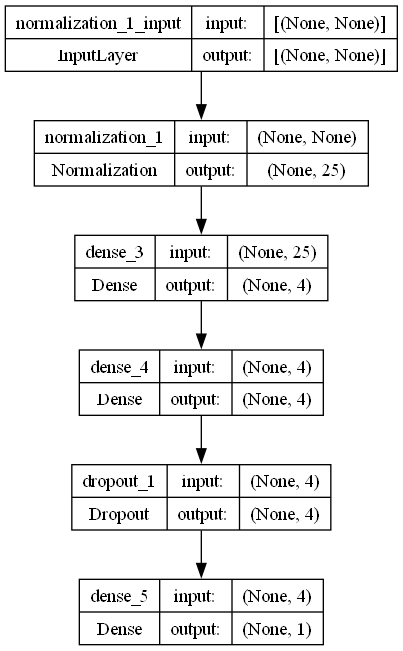

In [48]:
plot_model(
    model, to_file='model.png', show_shapes=True, 
    show_layer_names=True, dpi=96
)

The goal is to predict failed test results, but we don't have very many of those positive samples to work with, so we would want to have the classifier heavily weight the few examples that are available. We can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class. Note, however, that this does not increase in any way the amount of information of your dataset. Let's see how it works out.

In [49]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = len(train_labels)
print(f"Total: {total}")
pos = sum(train_labels)
print(f"POS: {pos}")
neg = total - pos
print(f"NEG: {neg}")

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Total: 92395
POS: 6458
NEG: 85937
Weight for class 0: 0.54
Weight for class 1: 7.15


In [50]:
training = model.fit(
    train_features,
    train_labels,
    batch_size=256,
    epochs=10,
    validation_data=(val_features, val_labels), 
    verbose=1,
    class_weight=class_weight)

Epoch 1/10
361/361 [==============================] - 2s 3ms/step - loss: 0.7050 - precision_1: 0.0795 - recall_1: 0.5906 - val_loss: 0.6573 - val_precision_1: 0.0827 - val_recall_1: 0.6717
Epoch 2/10
361/361 [==============================] - 1s 2ms/step - loss: 0.6808 - precision_1: 0.0835 - recall_1: 0.7385 - val_loss: 0.6680 - val_precision_1: 0.0889 - val_recall_1: 0.6999
Epoch 3/10
361/361 [==============================] - 1s 2ms/step - loss: 0.6700 - precision_1: 0.0897 - recall_1: 0.7386 - val_loss: 0.6579 - val_precision_1: 0.1008 - val_recall_1: 0.6974
Epoch 4/10
361/361 [==============================] - 1s 2ms/step - loss: 0.6583 - precision_1: 0.0959 - recall_1: 0.7425 - val_loss: 0.6429 - val_precision_1: 0.1070 - val_recall_1: 0.6836
Epoch 5/10
361/361 [==============================] - 1s 2ms/step - loss: 0.6522 - precision_1: 0.0993 - recall_1: 0.7293 - val_loss: 0.6463 - val_precision_1: 0.1109 - val_recall_1: 0.7006
Epoch 6/10
361/361 [==============================

Let's have a look at our recall at each epoch on the train- and validation set

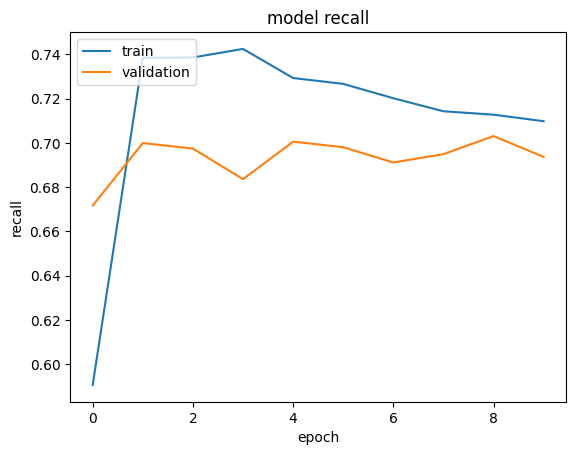

In [53]:
# summarize history for recall
plt.plot(training.history['recall_1'])
plt.plot(training.history['val_recall_1'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Exercise:** 
Plot the loss against the epochs, and discuss the result!

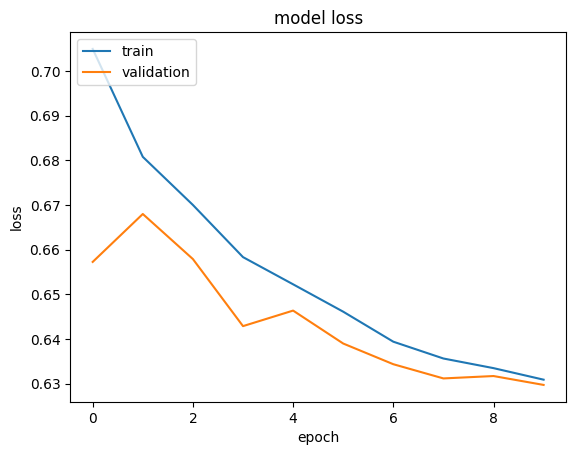

In [54]:
# summarize history for loss
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

903/903 [==============================] - 1s 1ms/step


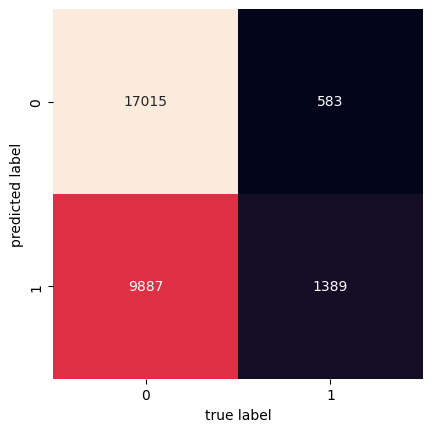

In [55]:
y_pred = model.predict(test_features)

# Plotting the confusing matrix
mat = confusion_matrix(test_labels, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [56]:
recall = recall_score(test_labels, y_pred.round())
round(recall, 2)

0.7

The recall tells us what fraction of the vehicles that will fail the emissions test, we actually catch. To reduce pollution in Albuquerque we want this to be as high as possible without having to test as few as possible vehicles who will pass the test. So that we save money.

**Exercise:** 
- What happens when you add layers to our model? 
- What happens when you change the number of nodes?
- What when you change the batch size or the optimizer?

In [60]:
# 1 - More layers

model_1 = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(4, activation='gelu'),
    tf.keras.layers.Dense(4, activation='gelu'),
    tf.keras.layers.Dense(4, activation='gelu'),
    tf.keras.layers.Dense(4, activation='gelu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_1.compile(optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.Precision(thresholds=0.5), tf.keras.metrics.Recall(thresholds=0.5)])

# Build the model so plot_model has concrete input shapes
model_1.build((None, train_features.shape[1]))

plot_model(
    model_1, to_file='model_1.png', show_shapes=True, 
    show_layer_names=True, dpi=96
)


# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = len(train_labels)
print(f"Total: {total}")
pos = sum(train_labels)
print(f"POS: {pos}")
neg = total - pos
print(f"NEG: {neg}")

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

training = model_1.fit(
    train_features,
    train_labels,
    batch_size=256,
    epochs=10,
    validation_data=(val_features, val_labels), 
    verbose=1,
    class_weight=class_weight)


Total: 92395
POS: 6458
NEG: 85937
Weight for class 0: 0.54
Weight for class 1: 7.15
Epoch 1/10
361/361 [==============================] - 2s 3ms/step - loss: 0.6975 - precision_5: 0.0741 - recall_5: 0.5424 - val_loss: 0.6878 - val_precision_5: 0.0840 - val_recall_5: 0.6058
Epoch 2/10
361/361 [==============================] - 1s 2ms/step - loss: 0.6822 - precision_5: 0.0881 - recall_5: 0.6627 - val_loss: 0.6694 - val_precision_5: 0.1031 - val_recall_5: 0.6748
Epoch 3/10
361/361 [==============================] - 1s 2ms/step - loss: 0.6409 - precision_5: 0.1173 - recall_5: 0.6830 - val_loss: 0.6256 - val_precision_5: 0.1251 - val_recall_5: 0.6748
Epoch 4/10
361/361 [==============================] - 1s 2ms/step - loss: 0.6263 - precision_5: 0.1263 - recall_5: 0.6847 - val_loss: 0.6138 - val_precision_5: 0.1285 - val_recall_5: 0.6780
Epoch 5/10
361/361 [==============================] - 1s 2ms/step - loss: 0.6214 - precision_5: 0.1296 - recall_5: 0.6919 - val_loss: 0.6260 - val_precision

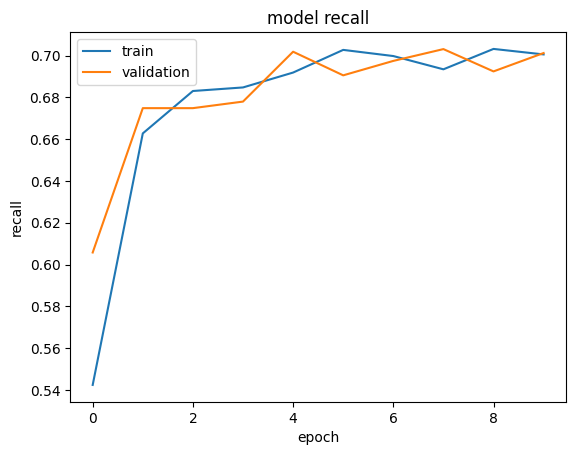

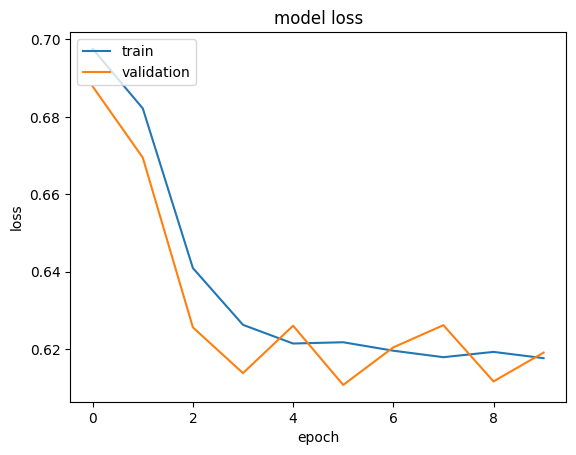

903/903 [==============================] - 1s 1ms/step


0.72

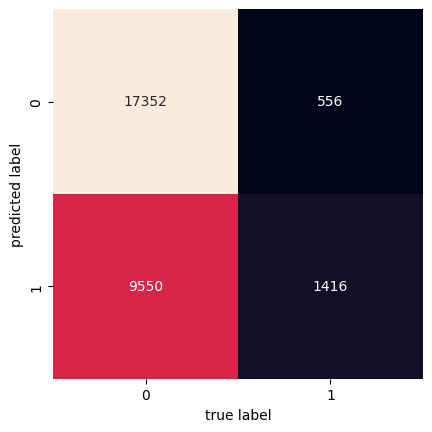

In [61]:

# summarize history for recall
plt.plot(training.history['recall_5'])
plt.plot(training.history['val_recall_5'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

y_pred_1 = model_1.predict(test_features)

# Plotting the confusing matrix
mat = confusion_matrix(test_labels, y_pred_1.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

recall_1 = recall_score(test_labels, y_pred_1.round())
round(recall_1, 2)